In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model

In [3]:
# 使用numpy读取中文路径的图像
def cv_imread(file_path):
    cv_img = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), cv2.IMREAD_COLOR)
    return cv_img

In [4]:
def FaceDetectorYN(model=False):
    return cv2.FaceDetectorYN.create(model,"",(320, 320),0.9,0.3,5000)

In [5]:
def FaceRecognizerSF(model=False):
    return cv2.FaceRecognizerSF.create(model,"")

In [6]:
def Detect(Detector , imgD , Width , Height):    
    Detector.setInputSize((Width, Height))
    return Detector.detect(imgD)

In [7]:
def Crop(recognizer , image , face):
    return recognizer.alignCrop(image, face[1][0])

In [8]:
def showImage(img , title):
    plt.title(title)
    return plt.imshow(img)

In [9]:
FaceRecognizer = FaceRecognizerSF('face_recognition.onnx')
FaceDetector = FaceDetectorYN('face_detection.onnx')

In [10]:
def reSize(img=False):
    _img = cv_imread(img)
    img1 = _img.copy()
    Width = int(img1.shape[1])
    Height = int(img1.shape[0])
    img1 = cv2.resize(img1, (Width, Height))
    return img1 , Height , Width

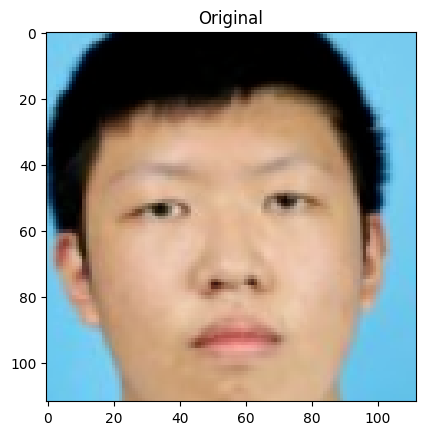

In [12]:
img , imgHeight , imgWidth = reSize("img/new/2021302181153-刘宇.png")

Face = Detect(FaceDetector , img , imgWidth , imgHeight)

faceAlign = Crop(FaceRecognizer , img , Face)
faceFeature = FaceRecognizer.feature(faceAlign)

showImage(faceAlign[...,::-1] , 'Original');

In [13]:
def Coords(frame , face , thickness):
    coords = face[:-1].astype(np.int32)
    cv2.rectangle(frame, (coords[0], coords[1]), (coords[0] + coords[2] , coords[1] + coords[3]) , (0, 255, 0), thickness)
    cv2.circle(frame, (coords[4], coords[5]), 2, (255, 0, 0), thickness)
    cv2.circle(frame, (coords[6], coords[7]), 2, (0, 0, 255), thickness)
    cv2.circle(frame, (coords[8], coords[9]), 2, (0, 255, 0), thickness)
    cv2.circle(frame, (coords[10], coords[11]), 2, (255, 0, 255), thickness)
    cv2.circle(frame, (coords[12], coords[13]), 2, (0, 255, 255), thickness)

In [14]:
# 加载预训练的 MobileNetV2 模型，不包括顶层
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# 添加自定义层
x = base_model.output
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Dropout(0.2, name='extra_dropout1')(x)
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid', name='classifier')(x)

In [15]:
# 构建整个模型
model = Model(inputs=base_model.input, outputs=output)
# 加载权重
model.load_weights('./models/mobilenetv2-best.hdf5')

In [16]:
# 初始化摄像头
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("无法打开摄像头")
    exit()

paused = False
check_authenticity = False
predicted_label = ''
l2_similarity_threshold = 0.05  # 根据实际情况调整
recognized_label = ''

while True:
    # 不暂停的情况下，从摄像头获取实时画面
    if not paused:
        ret, frame = cap.read()
        if not ret:
            print("无法从摄像头读取图像")
            break
        frame = cv2.flip(frame, 1)

    # 如果点击 'p' 切换暂停状态并标记判断
    if check_authenticity:
        img = cv2.resize(frame, (224, 224))
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)
        prediction = model.predict(img)
        print(prediction[0][0])
        predicted_label = '真人' if prediction[0][0] > l2_similarity_threshold else '图片或视频'

        # 如果是真人，进行人脸检测和识别
        if predicted_label == '真人':
            result = Detect(FaceDetector, frame, frame.shape[1], frame.shape[0])

            if result[1] is not None:
                for idx, face in enumerate(result[1]):
                    Coords(frame, face, 2)
                    face_aligned = Crop(FaceRecognizer, frame, result)
                    face_feature = FaceRecognizer.feature(face_aligned)

                    recognized_label = '识别成功'
                    break  # 只需识别一个人脸
            else:
                recognized_label = '没有检测到人脸'
        else:
            recognized_label = '非真人，识别失败'

        check_authenticity = False  # 重置标志

    # 使用PIL添加中文文本
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(frame_pil)
    font = ImageFont.truetype("simsun.ttc", 32)
    draw.text((10, 30), predicted_label, font=font, fill=(0, 255, 0))
    draw.text((10, 70), recognized_label, font=font, fill=(0, 255, 0))
    frame = cv2.cvtColor(np.array(frame_pil), cv2.COLOR_RGB2BGR)

    # 显示图像
    cv2.imshow('Webcam', frame)

    # 键盘输入控制
    key = cv2.waitKey(100)
    if key & 0xFF == ord('q'):
        break
    elif key & 0xFF == ord('p'):
        paused = not paused
        check_authenticity = True

# 释放资源
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 859ms/step
0.3556774
